<a href="https://colab.research.google.com/github/wujianming/100-Days-of-ML-Code-Chinese-Version/blob/master/Ecommerce_Image_Classification_with_Marqo_FashionCLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Ecommerce Image Classification with Marqo-FashionCLIP**

Marqo have recently announced two new state-of-the-art embedding models for multimodal fashion search and recommendations: [Marqo-FashionCLIP](https://huggingface.co/Marqo/marqo-fashionCLIP) & [Marqo FashionSigLIP](https://huggingface.co/Marqo/marqo-fashionSigLIP). In this notebook, we will explore how you can build your own simple ecommerce image classification with Marqo-FashionCLIP.

The article to accompany this notebook can be found here: https://www.marqo.ai/blog/ecommerce-image-classification-with-marqo-fashionclip

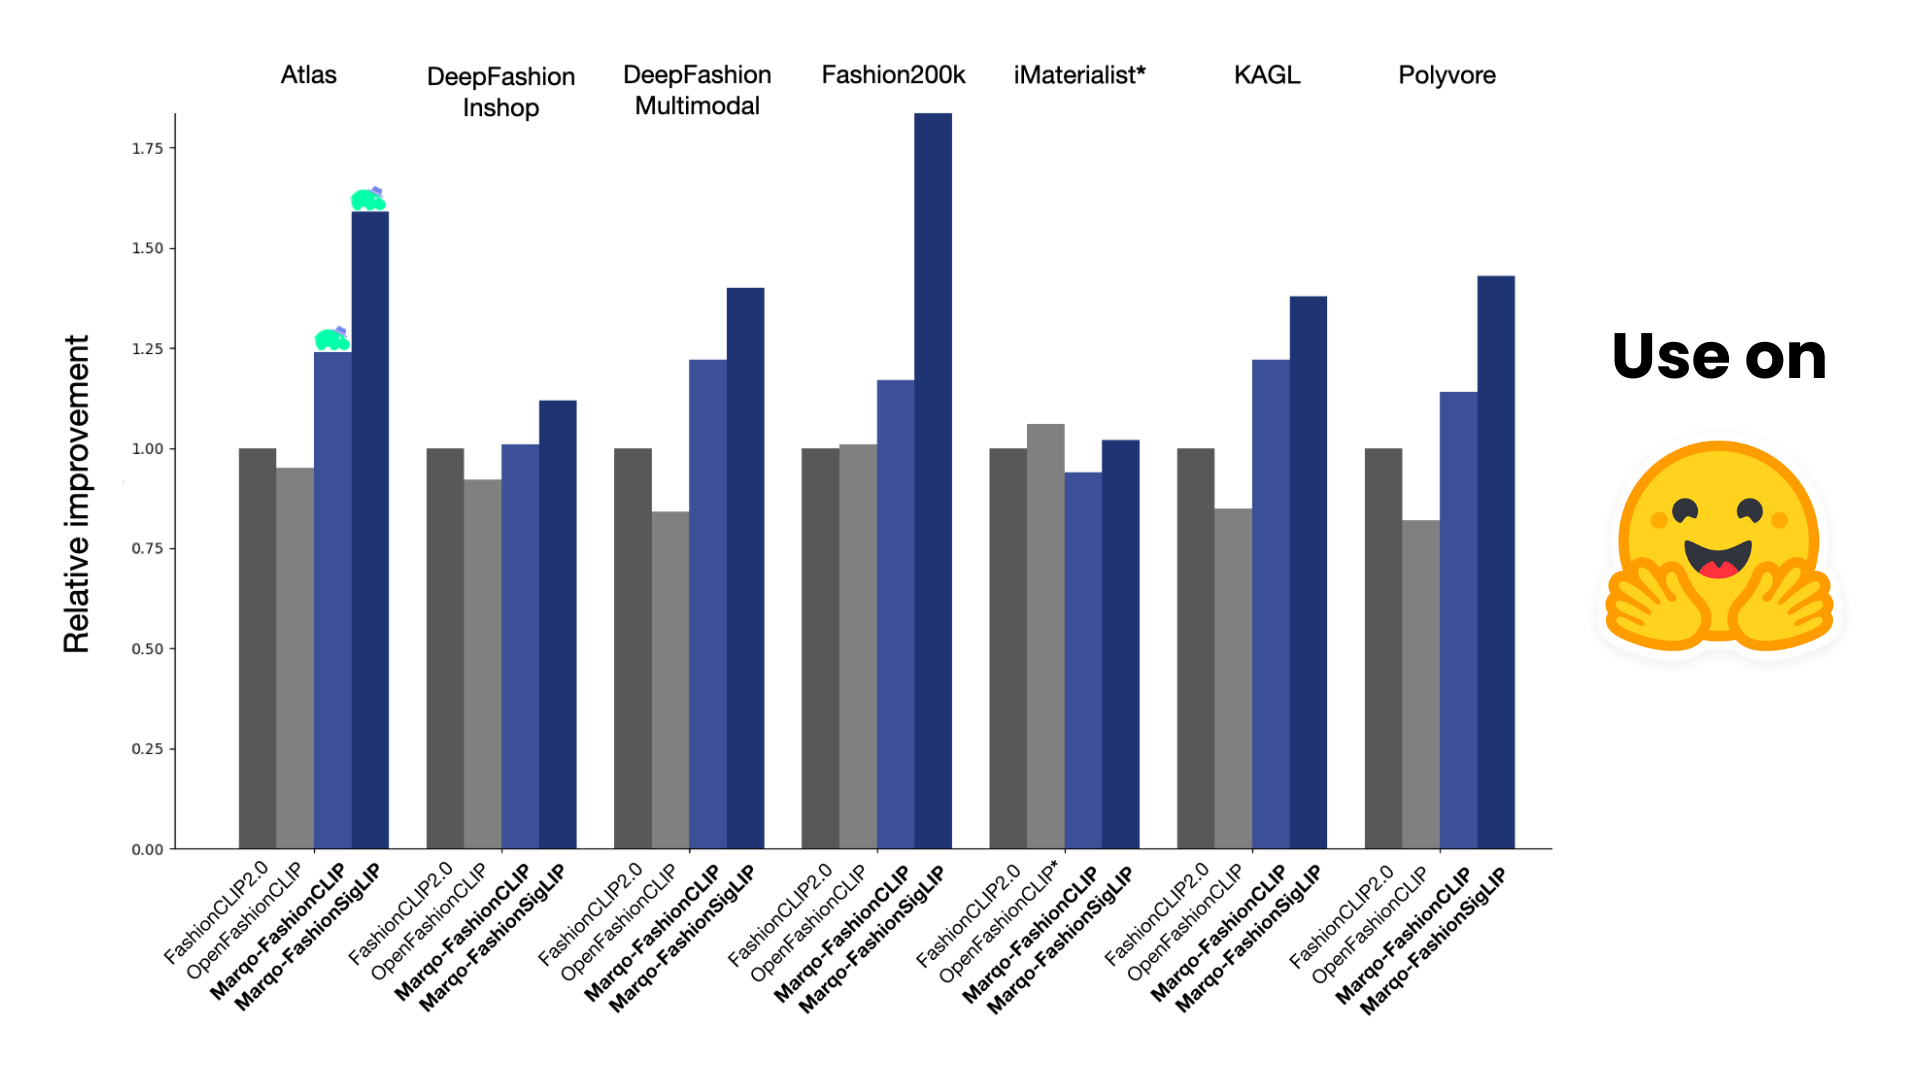

### **1. Installation**
We first begin by installing the relevant modules needed for this example. We install `open_clip` and `datasets` which will allow us to load our embedding models and datasets, respectively.

In [ ]:
!pip install open_clip_torch
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 2.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

### **2. Load a Dataset**

Since we are performing ecommerce image classification, we will need an ecommerce or fashion dataset. For this demo, we choose [`ceyda/fashion-products-small`](https://huggingface.co/datasets/ceyda/fashion-products-small) which is a small collection of fashion products.

In [ ]:
from datasets import load_dataset

# Load the dataset
ds = load_dataset('ceyda/fashion-products-small')

Repo card metadata block was not found. Setting CardData to empty.


Let's take a look at the features inside this dataset by printing `ds`:

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['filename', 'link', 'id', 'masterCategory', 'gender', 'subCategory', 'image'],
        num_rows: 42700
    })
})

We see that we have `filename`, `link`, `id`, `masterCategory`, `gender`, `subCategory` and `image`. Let's print the first example from this dataset to see what these features mean:

In [ ]:
entry = ds['train'][0]
entry

{'filename': '15970.jpg',
 'link': 'http://assets.myntassets.com/v1/images/style/properties/7a5b82d1372a7a5c6de67ae7a314fd91_images.jpg',
 'id': '15970',
 'masterCategory': 'Apparel',
 'gender': 'Men',
 'subCategory': 'Topwear',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=384x512>}

Thus, the features of the dataset are as follows:

* `filename`: this is the filename of the image, indicating that the image is stored or identified with this name.
* `link`: this is a URL link to the actual image file, which is hosted online. This link can be used to view or download the image.
* `id`: this is a unique identifier for the image, which can be used to reference this specific item within the dataset.
* `masterCategory`: this indicates the broad category under which this product falls.
* `gender`: this specifies the intended gender for the product, in this case, men's clothing.
* `subCategory`: this is a more specific category within the master category. "Topwear" indicates that the product is an item of clothing worn on the upper body, such as a shirt, t-shirt, or jacket.
* `image`: this is a PIL (Python Imaging Library) image object, which allows for image manipulation and processing. It specifies the image mode (RGB, meaning it has red, green, and blue color channels) and the image size (384 pixels wide by 512 pixels tall).

Cool, let’s look at the image!

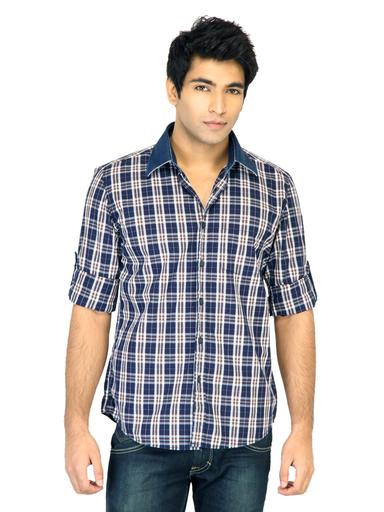

In [ ]:
image = entry['image']
image

As expected, it's an item of men's topwear.

We can see that the data itself is comprised of a train dataset, so we will define our dataset as this.

In [ ]:
dataset = ds['train']

### **Load Marqo-FashionCLIP Model and Preprocessing**

For this demo, we will be using the Marqo-FashionCLIP model (`Marqo/marqo-fashionCLIP`) which is a state-of-the-art multimodal models for search and recommendations in the fashion domain. For more information about the model, visit this [article](https://www.marqo.ai/blog/search-model-for-fashion). The model and its preprocessing function are loaded. The model is moved to the appropriate device (GPU if available, otherwise CPU).

In [ ]:
import open_clip
import torch

# Load the Marqo/marqo-fashionCLIP model and preprocessors
model, preprocess_train, preprocess_val = open_clip.create_model_and_transforms('hf-hub:Marqo/marqo-fashionCLIP')
tokenizer = open_clip.get_tokenizer('hf-hub:Marqo/marqo-fashionCLIP')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-11): 12 x ResidualAttentionBlock(
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_post): LayerNorm((768,), eps=1e-05, elementwise_affine

### **Perform Image Classification with Marqo-FashionCLIP**

Let's take a look at our Marqo-FashionCLIP model predictions for image classification on this dataset.

This code uses the CLIP model to classify three example images from our dataset by comparing their visual features with textual descriptions of subcategories. It processes and normalizes the features of the images and subcategory texts, calculates their similarity, and predicts the subcategory for each image. Finally, it visualizes the images alongside their predicted and actual subcategories in a plot.

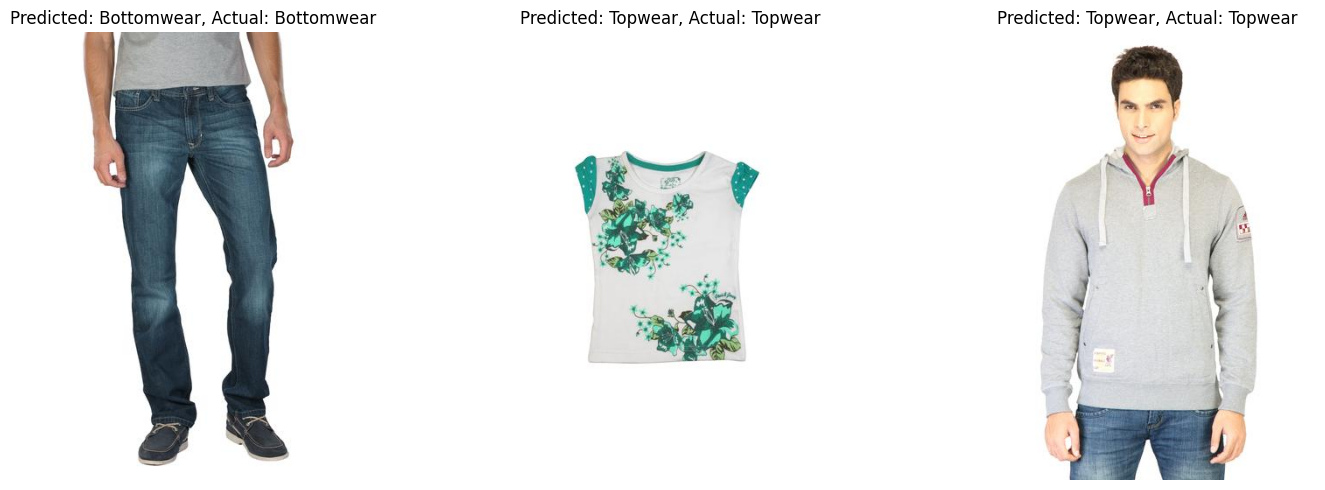

In [ ]:
import matplotlib.pyplot as plt

# Select indices for three example images
indices = [1, 17, 23]

# Get the list of possible subcategories from the dataset
subcategories = list(set(example['subCategory'] for example in dataset))

# Preprocess the text descriptions for each subcategory using the tokenizer
text_inputs = tokenizer([f"a photo of {c}" for c in subcategories]).to(device)

# Create a figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Loop through the indices and process each image
for i, idx in enumerate(indices):
    # Select an example image from the dataset
    example = dataset[idx]
    image = example['image']
    subcategory = example['subCategory']

    # Preprocess the image
    image_input = preprocess_val(image).unsqueeze(0).to(device)

    # Calculate image and text features
    with torch.no_grad():
        image_features = model.encode_image(image_input)
        text_features = model.encode_text(text_inputs)

    # Normalize the features
    image_features /= image_features.norm(dim=-1, keepdim=True)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    # Calculate similarity between image and text features
    similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
    values, indices = similarity[0].topk(1)

    # Display the image in the subplot
    axes[i].imshow(image)
    axes[i].set_title(f"Predicted: {subcategories[indices[0]]}, Actual: {subcategory}")
    axes[i].axis('off')

# Show the plot
plt.tight_layout()
plt.show()

Nice! Our model is able to predict the images in this dataset.

### **Conclusion**

In this notebook, we've used Marqo-FashionCLIP for image classification on a small fashion dataset. We performed image classification for three specific images from the dataset and computed the predicted sub-category for each image and compared these with the true sub-category.

### **Additional Resources**

* Marqo-Fashion CLIP on [Hugging Face](https://huggingface.co/Marqo/marqo-fashionCLIP)
* Marqo-Fashion CLIP on [GitHub](https://github.com/marqo-ai/marqo-FashionCLIP/tree/main)
* Article: [Marqo Launches Family of Embedding Models for Ecommerce and Retail](https://www.marqo.ai/blog/search-model-for-fashion)